# Miniproject 3: Poem Generation

### Download Data

In [4]:
import requests

url_dict = {
    'shakespeare.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/shakespeare.txt',
    'spenser.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/spenser.txt',
    'syllable_dict.txt' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/Syllable_dictionary.txt',
    # 'about_syllable_dict.docx' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/syllable_dict_explanation.docx'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('shakespeare.txt')
download_file('spenser.txt')
download_file('syllable_dict.txt')
download_file('about_syllable_dict.docx')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


KeyError: 'about_syllable_dict.docx'

### Preprocessing: each poem treated as a single sequence

In [2]:
import re

# grab all poems and separate them by word
with open('shakespeare.txt', 'r') as file:
    text = file.read()
poem_pattern = r'\s*(\d+)\s*(.*?)\s*(?=^\s*\d+|\Z)'  # chatGPT
poem_matches = re.findall(poem_pattern, text, re.DOTALL | re.MULTILINE)
poems = []
for match in poem_matches:
    poems.append(match[1].strip())

# hyphens and apostrophes treated as joining two parts of a word
# and punctuation ,.?!:; are treated as separated tokens
pattern = r'([\w\'-]+\b|[,.?!:;]|\n)'
all_poem_word_list = []
for poem in poems:
    words = re.findall(pattern, poem)
    all_poem_word_list.append([word.lower() for word in words])
print(f'Number of poems: {len(all_poem_word_list)}')

# Generate the word to index mapping
word_to_idx = {}
idx = 0
for poem in all_poem_word_list:
    for obs in poem:
        if word_to_idx.get(obs) is None:
            word_to_idx.update({obs: idx})
            idx += 1
word_to_idx.update({'END': idx})
idx_to_word = {v: k for k, v in word_to_idx.items()}
print(f'Number of unique observations (including END, punctuation, and newline): {len(word_to_idx)}')

all_observations = []
for poem in all_poem_word_list:
    all_observations.append([word_to_idx.get(word) for word in poem] + [word_to_idx.get('END')])

Number of poems: 154
Number of unique observations (including END, punctuation, and newline): 3222


In [3]:
from set6hmm import *

HMM = unsupervised_HMM(all_observations, n_states=10, N_iters=10)

epoch 1/2
epoch 2/2


In [13]:
HMM.end = [word_to_idx.get('END')]
emission = HMM.generate_emission(160)   # ~average length
for emit in emission[0]:
    emit_word = idx_to_word.get(emit)
    if emit_word == '\n':
        print()
    elif emit_word == 'END':
        break
    elif not emit_word.isalnum():   # is punctuation
        print(emit_word)
    else:
        print(emit_word, end=' ')
print()
print(f'Length of this emission: {len(emission[0])}')

me 'tis
not do though so abysm place hadst pity lion's
scope woe only number former that dancing in lovely me are thy the your beauty's
as my no to old 
.
usurer aid all thoughts ,

acknowledge be of and the fresh all 
read is in time's
night varying travel be of .
heaven chest with ,
become muse a-doting
love his looks huge ,
so against own thy maketh 
might still mine to but 
which terms ?
obsequious then summer's
,

in soil is write 
Length of this emission: 94


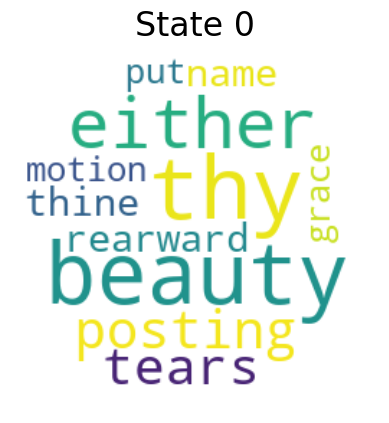

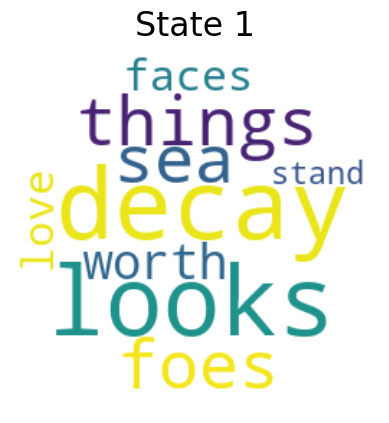

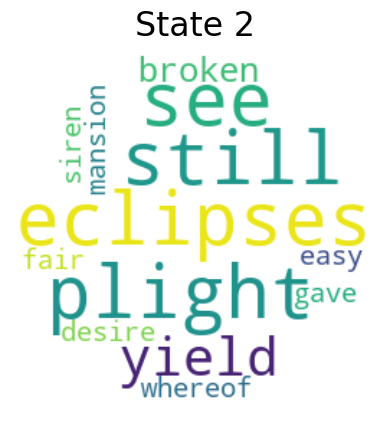

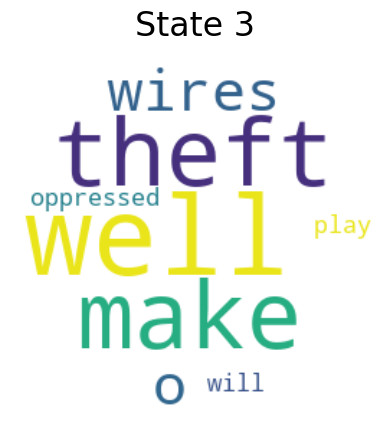

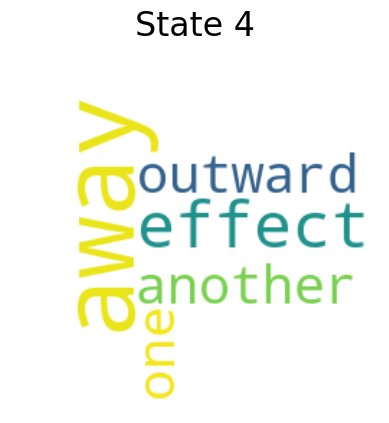

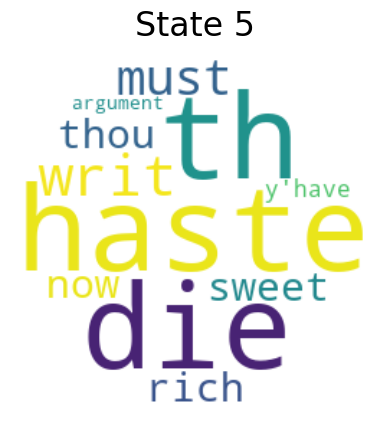

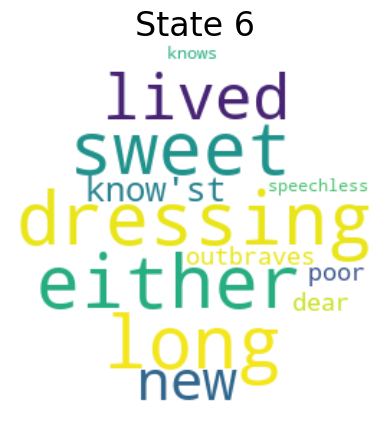

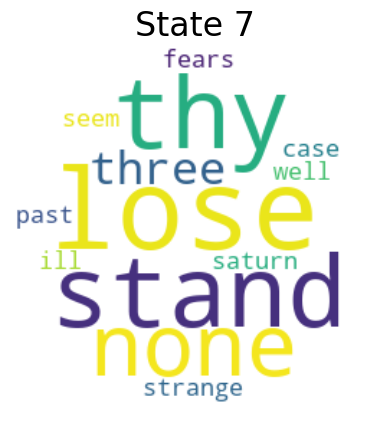

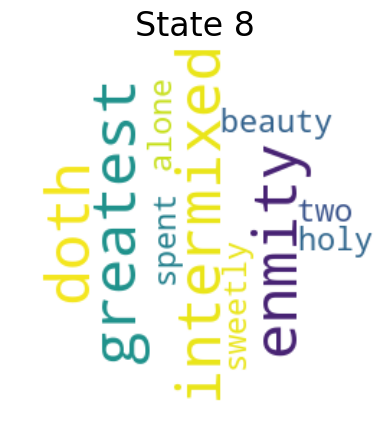

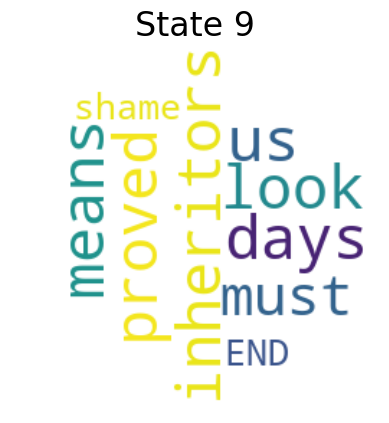

In [16]:
from wordcloud_utils import states_to_wordclouds
wordclouds = states_to_wordclouds(HMM, idx_to_word, max_words=100)